# Single-cell virus sequencing
This example shows how to use [alignparse](https://jbloomlab.github.io/alignparse/) to process full-length PacBio CCSs of viral cDNAs generated in single-cell virus sequencing of influenza-infected cells.
Specifically, it processes a snippet of data taking from [Russell et al, 2019](https://jvi.asm.org/content/93/14/e00500-19), which was generated by PacBio sequencing of viral cDNAs with unique molecular identifiers (UMIS) and cell barcodes added using a 10X Chromium (v2 reagents).
This notebook aligns these CCSs to the influenza transcripts and parses the barcodes / UMIs and viral mutations.

## Set up for analysis
Import necessary Python modules.
We use [alignparse](https://jbloomlab.github.io/alignparse/) for most of the operations, [plotnine](https://plotnine.readthedocs.io) for ggplot2-like plotting, and a few functitons from [dms_variants](https://jbloomlab.github.io/dms_variants):

In [1]:
import os
import warnings

import numpy

import pandas as pd

from plotnine import *

import alignparse.ccs
import alignparse.consensus
import alignparse.minimap2
import alignparse.targets
from alignparse.constants import CBPALETTE

import dms_variants.plotnine_themes
import dms_variants.utils

Suppress warnings that clutter output:

In [2]:
warnings.simplefilter('ignore')

Set [plotnine](https://plotnine.readthedocs.io/en/stable/) theme to the one defined in [dms_variants](https://jbloomlab.github.io/dms_variants):

In [3]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())

Directory for output:

In [4]:
outdir = './output_files/'
os.makedirs(outdir, exist_ok=True)

## Target amplicons
The alignment targets consist of PCR amplicons covering the influenza virus mRNAs (WSN strain) with a 5' termini corresponding to the primer binding site, the 3' polyA tail used for reverse transcription, the UMI and cell barcode, and the common 3' termini.
There are also variant tags distinguishing the synonymously tagged viral variants (see [Russell et al, 2019](https://jvi.asm.org/content/93/14/e00500-19)).

First, let's look at the Genbank file holding the targets.
The targets are defined in [Genbank Flat File format](https://www.ncbi.nlm.nih.gov/genbank/samplerecord/)
Below we show the first 85 lines (the actual file is quite large as it defined all 10 influenza mRNAs):

In [5]:
targetfile = 'input_files/flu_WSN_amplicons.gb'

nlines_to_show = 85
with open(targetfile) as f:
    print(''.join(next(f) for _ in range(nlines_to_show)))

LOCUS       fluPB2                  2395 bp    DNA              UNK 01-JAN-1980
DEFINITION  fluPB2.
ACCESSION   fluPB2
VERSION     fluPB2
KEYWORDS    .
SOURCE      .
  ORGANISM  .
            .
FEATURES             Location/Qualifiers
     termini5        1..34
     variant_tag_1   143..143
     variant_tag_2   149..149
     variant_tag_3   2163..2163
     variant_tag_4   2171..2171
     sequenced_mRNA  35..2316
     final_mRNA_nts  2317..2319
     polyA           2320..2347
     UMI             2348..2357
     cellbarcode     2358..2373
     termini3        2374..2395
ORIGIN
        1 gcgaaagcag gtcaattata ttcaatatgg aaagaataaa agaactaagg aatctaatgt
       61 cgcagtctcg cactcgcgag atactcacaa aaaccaccgt ggaccatatg gccataatca
      121 agaagtacac atcaggaaga cargagaara acccagcact taggatgaaa tggatgatgg
      181 caatgaaata tccaattaca gcagacaaga ggataacgga aatgattcct gagagaaatg
      241 agcagggaca aactttatgg agtaaaatga atgacgccgg atcagaccga gtgatggtat
      301 cacctctggc tgtgacatgg tggaa

We also have the YAML file specifying how to parse the features in the alignments.
Note how this file uses the YAML syntax for defaults to avoid repeating the same specifications for each target:

In [6]:
feature_parse_specs_file = 'input_files/flu_WSN_feature_parse_specs.yaml'
with open(feature_parse_specs_file) as f:
    print(f.read())

# default for genes with two variant tags
default_2tags: &default_2tags
  query_clip5: 4
  query_clip3: 4
  termini5:
    filter:
      clip5: 4
      mutation_nt_count: 1
      mutation_op_count: null
  sequenced_mRNA:
    filter:
      mutation_nt_count: null
      mutation_op_count: 10
    return: [mutations, accuracy]
  final_mRNA_nts:
    filter:
      mutation_nt_count: null
      mutation_op_count: 2
  polyA:
    filter:
      mutation_nt_count: 12
      mutation_op_count: 4
  UMI:
    return: [sequence, accuracy]
  cellbarcode:
    return: [sequence, accuracy]
  termini3:
    filter:
      clip5: 4
      mutation_nt_count: 1
      mutation_op_count: null
  variant_tag_1:
    filter:
      mutation_nt_count: 1
      mutation_op_count: null
    return: sequence
  variant_tag_2:
    filter:
      mutation_nt_count: 1
      mutation_op_count: null
    return: sequence

# default for genes with four variant tags
default_4tags: &default_4tags
  <<: *default_2tags
  variant_tag_3:
   

We now read the targets into an [alignparse.targets.Targets](https://jbloomlab.github.io/alignparse/alignparse.targets.html#alignparse.targets.Targets) object with the feature-parsing specs (ignoring the keys that define thet defaults):

In [7]:
targets = alignparse.targets.Targets(
                seqsfile=targetfile,
                feature_parse_specs=feature_parse_specs_file,
                ignore_feature_parse_specs_keys=['default_2tags',
                                                 'default_4tags'],
                allow_extra_features=True)

Plot the [Targets](https://jbloomlab.github.io/alignparse/alignparse.targets.html#alignparse.targets.Targets):

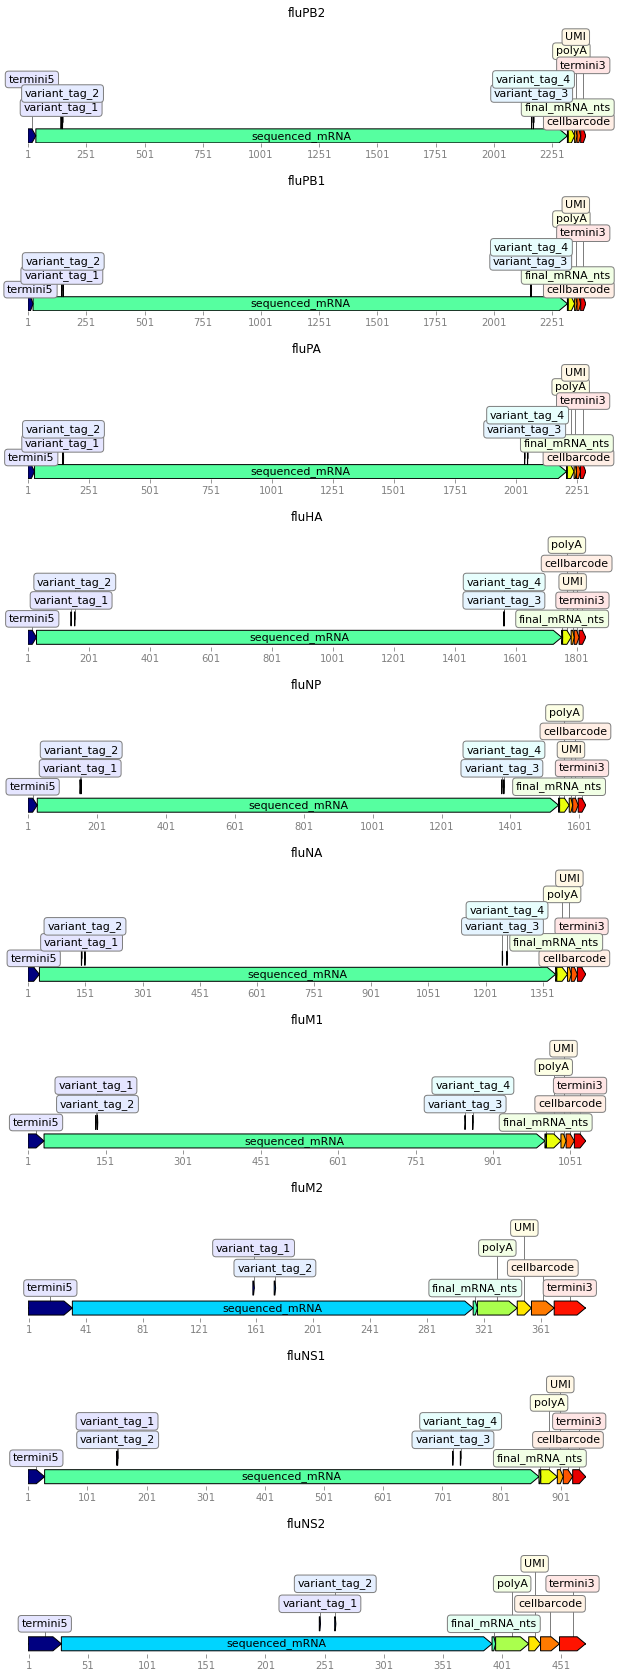

In [8]:
_ = targets.plot(ax_width=10)

Several things of note about how these targets are defined.
These all relate to the fact that the most difficult region to parse is the polyA tail and the UMI / cell barcode--the reason being that the polyA tail is not sequenced very accurately (it is a homopolymer) plus appears to be somewhat impure in the actual primers, so is difficult to align correctly.
This is compounded by the fact that we don't know the actual UMI sequence and so don't want indels of the polyA tail to "bleed" into the UMI or gene alignment.
Therefore:

 - We define a separate feature for the final nucleotides (last 3) of the mRNA upstream of the sequenced mRNA, so polyA indels don't get assigned to the sequenced mRNA too often.
 - We define the polyA to be just 28 nucleotides in the alignment even though the length in the primer is 30, so that deletions don't affect the UMI.
 
These empirically help with the alilgnments.

## PacBio CCSs
Now let's look at the PacBio CCSs.
First, define a data frame with the information on the PacBio runs (here we just have one):

In [9]:
pacbio_runs = pd.DataFrame(
            {'name': ['flu_WSN'],
             'fastq': ['input_files/flu_WSN_ccs.fastq']
             })

pacbio_runs

,name,fastq
0,flu_WSN,input_files/flu_WSN_ccs.fastq


Create an [alignparse.ccs.Summaries](https://jbloomlab.github.io/alignparse/alignparse.ccs.html#alignparse.ccs.Summaries) object:

In [10]:
ccs_summaries = alignparse.ccs.Summaries(pacbio_runs,
                                         report_col=None)

Statistics on the CCSs (length, number of subread passes, quality):

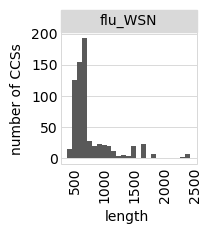

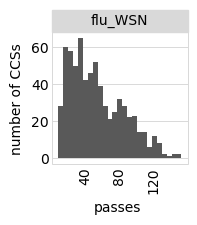

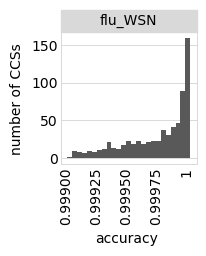

In [11]:
for stat in ['length', 'passes', 'accuracy']:
    if ccs_summaries.has_stat(stat):
        p = ccs_summaries.plot_ccs_stats(stat)
        p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
        _ = p.draw()
    else:
        print(f"No {stat} statistics available.")

## Align and parse
First, we create an [alignparse.minimap2.Mapper](https://jbloomlab.github.io/alignparse/alignparse.minimap2.html#alignparse.minimap2.Mapper) to run [minimap2](https://github.com/lh3/minimap2), which is used for the alignments. We use [minimap2](https://github.com/lh3/minimap2) options that are tailored for viruses with potentially large internal deletions (which are handled like spliced introns); these options are specified by [alignparse.minimap2.OPTIONS_VIRUS_W_DEL](https://jbloomlab.github.io/alignparse/alignparse.minimap2.html#alignparse.minimap2.OPTIONS_VIRUS_W_DEL):

In [12]:
mapper = alignparse.minimap2.Mapper(alignparse.minimap2.OPTIONS_VIRUS_W_DEL)

print(f"Using `minimap2` {mapper.version} with these options:\n" +
      ' '.join(mapper.options))

Using `minimap2` 2.17-r941 with these options:
-xsplice:hq -un -C0 --splice-flank=no -M=1 --end-seed-pen=2 --end-bonus=2 --secondary=no --cs


Now use [Targets.align_and_parse](https://jbloomlab.github.io/alignparse/alignparse.targets.html#alignparse.targets.Targets.align_and_parse) to align and parse the CCSs.
First, create the output directory:

In [13]:
align_and_parse_outdir = os.path.join(outdir, 'flu_WSN_align_and_parse')

Now do the alignments and parsing:

In [14]:
readstats, aligned, filtered = targets.align_and_parse(
        df=pacbio_runs,
        mapper=mapper,
        outdir=align_and_parse_outdir,
        name_col='name',
        queryfile_col='fastq',
        overwrite=True,  # overwrite any existing output
        ncpus=-1,  # use all available CPUs
        )

First, let's look at the read alignment stats:

In [15]:
readstats

,name,category,count
0,flu_WSN,filtered fluPB2,15
1,flu_WSN,aligned fluPB2,50
2,flu_WSN,filtered fluPB1,34
3,flu_WSN,aligned fluPB1,165
4,flu_WSN,filtered fluPA,36
5,flu_WSN,aligned fluPA,173
6,flu_WSN,filtered fluHA,2
7,flu_WSN,aligned fluHA,8
8,flu_WSN,filtered fluNP,6
9,flu_WSN,aligned fluNP,23


Plot these stats:

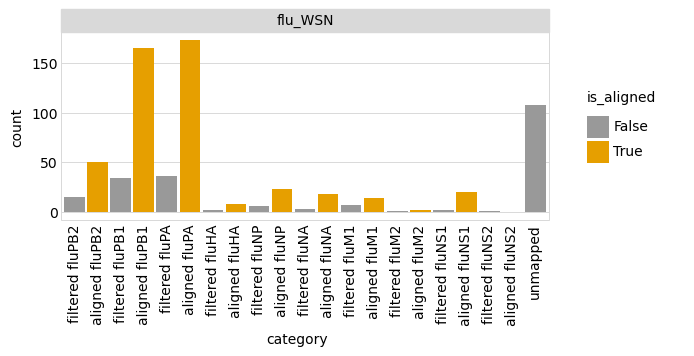

In [16]:
p = (
    ggplot(readstats.assign(
               category=lambda x: pd.Categorical(x['category'],
                                                 x['category'].unique(),
                                                 ordered=True),
               is_aligned=lambda x: x['category'].str.contains('aligned'),
               ),
           aes('category', 'count', fill='is_aligned')) +
    geom_bar(stat='identity') +
    facet_wrap('~ name', nrow=1) +
    theme(axis_text_x=element_text(angle=90),
          figure_size=(0.3 * len(readstats), 2.5),
          panel_grid_major_x=element_blank()  # no vertical grid lines
          ) +
    scale_fill_manual(values=CBPALETTE)
    )
_ = p.draw()

Now let's look at the reason that reads that were filtered failed to align.
Recall that `filtered` holds a data frame for each target:

In [17]:
for target in targets.target_names[:1]:
    print(f"First few lines of `filtered` for {target}:")
    display(filtered[target].head())

First few lines of `filtered` for fluPB2:


,name,query_name,filter_reason
0,flu_WSN,m54228_171201_172448/5308608/ccs,termini5 clip5
1,flu_WSN,m54228_171201_172448/6554482/ccs,polyA mutation_nt_count
2,flu_WSN,m54228_171201_172448/7143925/ccs,polyA mutation_nt_count
3,flu_WSN,m54228_171201_172448/9437481/ccs,final_mRNA_nts mutation_op_count
4,flu_WSN,m54228_171201_172448/9830886/ccs,polyA mutation_nt_count


Concatenate the information for all of the targets and plot reasons why mapped reads were filtered:

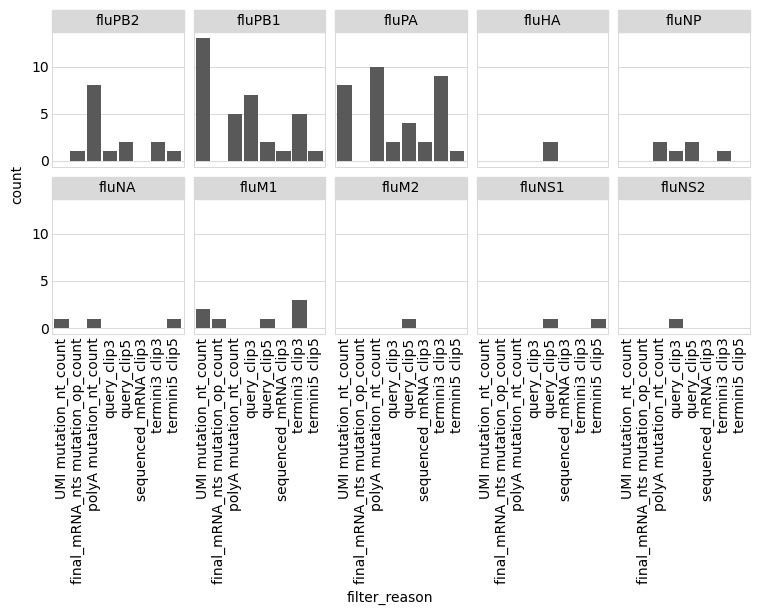

In [18]:
p = (
    ggplot(pd.concat([df.assign(gene=gene) for gene, df
                      in filtered.items()])
             .assign(gene=lambda x: pd.Categorical(x['gene'],
                                                   x['gene'].unique(),
                                                   ordered=True)),
           aes('filter_reason')) +
    geom_bar() +
    facet_wrap('~ gene', ncol=5) +
    theme(axis_text_x=element_text(angle=90),
          figure_size=(9, 4),
          panel_grid_major_x=element_blank(),  # no vertical grid lines
          )
    )

_ = p.draw()

Now let's look at the first few aligned reads for the first few genes:

In [19]:
for target in targets.target_names[:4]:
    print(f"\nFirst few entries in `aligned` for {target}:")
    display(aligned[target].head())


First few entries in `aligned` for fluPB2:


,name,query_name,query_clip5,query_clip3,sequenced_mRNA_mutations,sequenced_mRNA_accuracy,UMI_sequence,UMI_accuracy,cellbarcode_sequence,cellbarcode_accuracy,variant_tag_1_sequence,variant_tag_2_sequence,variant_tag_3_sequence,variant_tag_4_sequence
0,flu_WSN,m54228_171201_172448/5243086/ccs,0,0,del279to1904 C2077A C2157A C2214A,1.0,CAATAGGTAC,1.0,AGTAGTCACTTCAAGC,1.0,G,G,C,C
1,flu_WSN,m54228_171201_172448/5833039/ccs,0,0,del117to2070,1.0,AGCGCTCTTT,1.0,ATAAGGTGACCTCTCA,1.0,A,A,T,T
2,flu_WSN,m54228_171201_172448/5898400/ccs,0,0,G67T del152to1989,1.0,TGTCACTGGC,1.0,TCGGAGCTGGTCTTAG,1.0,G,G,C,C
3,flu_WSN,m54228_171201_172448/6160599/ccs,0,0,G242T C430G del551to2282,1.0,CTCGGTCCGC,1.0,GTGCGCATGGAAATCA,1.0,G,G,,
4,flu_WSN,m54228_171201_172448/6161088/ccs,0,0,del152to1989 G2057T G2118T,1.0,GGTTGGCGCT,1.0,CGGAGCTGGTCTTTAG,1.0,G,G,C,C



First few entries in `aligned` for fluPB1:


,name,query_name,query_clip5,query_clip3,sequenced_mRNA_mutations,sequenced_mRNA_accuracy,UMI_sequence,UMI_accuracy,cellbarcode_sequence,cellbarcode_accuracy,variant_tag_1_sequence,variant_tag_2_sequence,variant_tag_3_sequence,variant_tag_4_sequence
0,flu_WSN,m54228_171201_172448/4784702/ccs,0,0,del171to2016 del2268to2268,1.000000,GCGTATCCTG,1.000000,CCTTCGTGATGATTGC,1.000000,T,C,C,T
1,flu_WSN,m54228_171201_172448/4785077/ccs,0,0,del180to2032,1.000000,GTGCATGTGT,1.000000,TTCAGCCTGTTCAAGC,1.000000,T,C,C,T
2,flu_WSN,m54228_171201_172448/4915675/ccs,0,0,del171to2016 del2070to2070,1.000000,CACAAACTAT,1.000000,GCACAGCTGACTGATC,1.000000,T,C,C,T
3,flu_WSN,m54228_171201_172448/5111911/ccs,0,0,ins397T C468T T1612C,0.999384,AGCGTGCCAC,0.999999,ATCCTGGCTGCGTCCA,0.999998,T,C,C,T
4,flu_WSN,m54228_171201_172448/5112319/ccs,0,0,del258to2001,1.000000,CAACGATGAC,1.000000,GGCCACAACGCGAATG,1.000000,T,C,C,T



First few entries in `aligned` for fluPA:


,name,query_name,query_clip5,query_clip3,sequenced_mRNA_mutations,sequenced_mRNA_accuracy,UMI_sequence,UMI_accuracy,cellbarcode_sequence,cellbarcode_accuracy,variant_tag_1_sequence,variant_tag_2_sequence,variant_tag_3_sequence,variant_tag_4_sequence
0,flu_WSN,m54228_171201_172448/4587763/ccs,0,0,del117to1927 C2159A,1.000000,AAACTAGTGG,1.0,AAGACATGATCAGTGT,1.0,T,,T,C
1,flu_WSN,m54228_171201_172448/4653834/ccs,0,0,del179to1839,1.000000,AGCACACATA,1.0,TCCCATTGAAAACACA,1.0,C,T,A,T
2,flu_WSN,m54228_171201_172448/4719236/ccs,0,0,C42A del179to1839,1.000000,ACTGAAACAA,1.0,TCCCGTTGAAAACACA,1.0,C,T,A,T
3,flu_WSN,m54228_171201_172448/4784775/ccs,0,0,del66to177 del265to1996 C2028T,0.999981,AATAGTTCCC,1.0,GGCAAACGAGACGCAA,1.0,,,A,T
4,flu_WSN,m54228_171201_172448/4850043/ccs,0,0,A64G ins402A del1063to1067 del1073to2180,0.999704,CATCATATTG,1.0,TGTGGTCCTACTGATC,1.0,T,C,,



First few entries in `aligned` for fluHA:


,name,query_name,query_clip5,query_clip3,sequenced_mRNA_mutations,sequenced_mRNA_accuracy,UMI_sequence,UMI_accuracy,cellbarcode_sequence,cellbarcode_accuracy,variant_tag_1_sequence,variant_tag_2_sequence,variant_tag_3_sequence,variant_tag_4_sequence
0,flu_WSN,m54228_171201_172448/4522378/ccs,0,0,G397A ins1145A del1251to1722,1.000000,TAGACCCTTT,1.00000,GAGTACACTATCGCGC,1.0,C,G,,
1,flu_WSN,m54228_171201_172448/6947580/ccs,0,0,del108to1459,1.000000,CTTTGGGGGG,0.99998,GTAGGTTTGTCACTAG,1.0,,,G,T
2,flu_WSN,m54228_171201_172448/7144230/ccs,2,0,C260A C262A ins288G del471to471 C1052A ins1450T,0.999627,CGTACGGCAG,1.00000,AAACTGGCTAGGAGCT,1.0,A,A,A,C
3,flu_WSN,m54228_171201_172448/7340424/ccs,0,0,G213A ins663A G1715A del1718to1722,0.999847,GCTTGCCGGC,1.00000,GGTCACTCTGCGTTAT,1.0,A,A,A,C
4,flu_WSN,m54228_171201_172448/8520141/ccs,0,0,G9T C153A del771to771 A1253C del1256to1722,0.999810,GTGCCAAGGA,1.00000,GAAAGGCTGGTACGAG,1.0,C,G,,
